In [1]:
import torch
import torch.nn as nn
from tony_dataset import CTGdataset
from neural_net import Neural_Net, train_nn
import sys, os
import pandas as pd
import numpy as np
from collections import Counter

# check computation device
device = ('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Computation device: {device}\n")

In [2]:
'''
STEP 1: LOADING DATASET
'''
CTG_dataset = CTGdataset()

train_dataset, test_dataset = torch.utils.data.random_split(CTG_dataset, 
    [int(0.6 * len(CTG_dataset)), len(CTG_dataset) - int(0.6 * len(CTG_dataset))])
# training vs testing ratio is 6:4

Consider hidden dimensions be 20, 40, 60, 80, 100, 120

In [3]:
def generate_data(model, test_dataset):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                            batch_size=len(test_dataset), 
                                            shuffle=True)
    # Iterate through test dataset, calculate testing accuracy
    for samples, labels in test_loader:
        outputs = model(samples)
        _, predicted = torch.max(outputs.data, 1)
    return samples, predicted

In [4]:
def summarize_data(hidden_dim):
    dir_path = f'synthetic_data/vary_width/dim_{hidden_dim}'
    y_path = dir_path + '/y.csv'
    summ_path = dir_path + '/summary.txt'

    data = pd.read_csv(y_path)
    y = list(data.iloc[:,0])
    counter = dict(Counter(y))
    dataset_length = sum(counter.values())
    for key in counter:
        counter[key] *= (100.0 / dataset_length) # calculate class distribution in percents

    orig_stdout = sys.stdout
    with open(summ_path, 'w') as f:
        sys.stdout = f
        msg = (
            f'There are 22 features in this synthetic dataset and 10 possible class labels.\n'
            f'The dataset has {dataset_length} number of samples. To create the dataset, I\n'
            'first trained a feedforward neural network on a portion of the CTG dataset,\n'
            'and then I generated the ground labels by channeling the holdout data through\n'
            'the trained NN.\n\n'
            'The NN has two hidden layers of Sigmoid activation functions, where each hidden \n'
            f'layer has {hidden_dim} nodes. The class distributions are as follows:\n'
        )
        print(msg)
        for i in range(10):
            num = 0.00 # default
            if i in counter:
                num = round(counter[i], 2)
            print(f'{i}. {num} percent are from class {i}')

    sys.stdout = orig_stdout

In [7]:
for hidden_dim in [20,40,60,80,100,120]:
    # Instantiate model class
    input_dim = 22  # 22 features in case of CTG
    output_dim = 10 # 10 class labels in case of CTG, _class = 10
    model = Neural_Net(input_dim, hidden_dim, output_dim)

    orig_stdout = sys.stdout

    # Warmstart the neural networks
    filepath = f'synthetic_data/vary_width/dim_{hidden_dim}/test_performance.txt'
    os.makedirs(os.path.dirname(filepath), exist_ok = True)

    with open(filepath, 'w') as sys.stdout:
        batch_size = 100
        train_nn(model, train_dataset, test_dataset, batch_size = batch_size, l_r = 0.005, num_epochs = 6)
        # num_epochs is chosen to make the test accuracies of all 6 NN models to be less than 50%,
        # so that these models don't end up simply replicating the dataset

    # Generate synthetic data with the neural networks
    x, y = generate_data(model, test_dataset)
    x_df, y_df = pd.DataFrame(x.numpy()), pd.DataFrame(y.numpy())
    x_df.to_csv(f'synthetic_data/vary_width/dim_{hidden_dim}/x.csv', index=False, header=False)
    y_df.to_csv(f'synthetic_data/vary_width/dim_{hidden_dim}/y.csv', index=False, header=False)

    sys.stdout = orig_stdout

    summarize_data(hidden_dim)  # write to .txt file that summarizes the class distribution

In [5]:
# hyperparameters for gridsearch use
timelimit = 600
datasets = ['CTG','balance-scale', 'breast-cancer', 'car-evaluation', 'hayes-roth', 'house-votes-84', 
            'soybean-small', 'spect', 'tic-tac-toe', 'monks-1', 'monks-2', 'monks-3']
alpha = [0, 0.01, 0.1]
depth = [2, 3, 4, 5]
seeds = [37, 42, 53]

In [10]:
import matplotlib.pyplot as plt

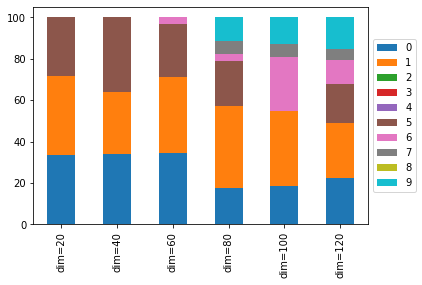

In [17]:
hidden_dims = [20,40,60,80,100,120]
records = {k:[0 for i in range(10)] for k in hidden_dims}

# Visualize the class distribution of the entire dataset
for hidden_dim in hidden_dims:
    dir_path = f'synthetic_data/vary_width/dim_{hidden_dim}'
    y_path = dir_path + '/y.csv'

    data = pd.read_csv(y_path)
    y = list(data.iloc[:,0])
    counter = dict(Counter(y))
    dataset_length = sum(counter.values())
    for key in counter:
        counter[key] *= (100.0 / dataset_length) # calculate class distribution in percents
        records[hidden_dim][key] = round(counter[key], 2)
df = pd.DataFrame.from_records(records)
ax = df.T.plot(kind='bar', stacked=True)
plt.xticks([i for i in range(6)], [f'dim={k}' for k in hidden_dims])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()